## TODO

1. Modeling
    * Finetune the existing models
    * Try DNN models
    * Create ensembles from models
    * Add a Naive Bayes model
2. Diagnostics
    * Calculate F1 score
3. Visualization of data

## Develop models to predict device failure
___Valentin Todorov___


#### Goal:
Build models to predict the probability of a device failure. When building this model, minimize false positives and false negatives.

## Plan for development
1. Setup the environment and read in the data
2. Data exploration
    * Calculate the distribution of total fail/not fail cases
    * Distribution of fail/not-fail cases by year
    * Distribution of fail/not-fail cases by month
    * Are there any devices that have higher failure rates than others
    * When a device fails, does it disappear from the data, or does it show up again
    * Seasonality of failures - are there particular days of the week when a higher percent of devices fail?
3. Understand the important variables for splitting the dataset
    * Do a pre-modeling analysis using random forest
    * Use decision trees to understand if I need to create categorical variables from some of the original features
4. Derive new features
    * Determine which features are categorical, and if needed create dummies
    * Since the data for some of the features is very sparse, create dummies which are 1, if data is available and 0 otherwise
    * Take logs of features
    * Scale the features
5. Sampling of the data
    * Create random samples from the data - 70% for training and 30% for validation
    * If the failures are too few compared to the non-failures, I will need to oversample the failures (and add a weight), or simply undersample the non-failures
6. Variables reduction
    * Random forest's variable importance    
    * Use decision trees
    * Use Recursive feature elimination (RFE)
    * Compare the suggested features from each method and decide which ones to keep in the modeling set
7. Decide on a methodology for the model estimation
    * Logistic regression - this will be a benchmark for all the rest of the methods
    * Random forest
    * XG Boosting
    * SVM
    * Neural network
8. Validate the results
9. Compare accuracy measures
    * Calculate accuracy, TP, FP, TN, FN, recall, etc.
    * Plot the performance for multiple modles using the ROC curve
    * Sensitivity/Recall
10. Create a confusion matrix - reduce false positives and false negatives

### Setup
Setup the environment and import needed packages

In [1]:
import pandas as pd
import numpy as np
from decimal import *
import graphviz
import matplotlib.pyplot as plt
import math
import seaborn as sns

import xgboost as xgb
import hdbscan
import sklearn.datasets as data
from imblearn.over_sampling import SMOTE
from sklearn import datasets, svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, roc_auc_score

# Inline plotting in jupyter
%matplotlib inline


/Users/valentin/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Define functions that I'll be using throughout the analysis
This section defines functions I'll use in the analysis, and the evaluation of results.

In [2]:
# This defines the path to the data depending on the OS I use - Win, macOS, or Ubuntu on AWS
def selectOS(_os):
    if _os == "win":
        data_location = "C:/Users/bre49823/GoogleDrive/Data/aws/device_failure.csv"
    elif _os == "mac":
        data_location = "/Users/valentin/GoogleDrive/Data/aws/device_failure.csv"
    elif _os == "aws":
        data_location = "/home/ubuntu/git/Gelos/data/device_failure.csv"
    return data_location

# Check for NA values in the data
def checkNaValues(df, columns_idx):
    features_na = []
    for i in range(0, len(columns_idx)):
        col = columns_idx[i]
        features_na.append(df[col].isnull().sum())
    return features_na

# Create log of features
def createLog(df, columns_list):
    for col in columns_list:
        column_log = col + "_log"    
        df[column_log] = df[col].apply(lambda x: 0 if x == 0 else math.log(x))
    return

# Take square root of features
def createSqrt(df, columns_list):
    for col in columns_list:
        column_sqrt = col + "_sqrt"
        df[column_sqrt] = np.sqrt(df[col])
    return

# Take square of features
def createSquare(df, columns_list):
    for col in columns_list:
        column_sq = col + "_sq"
        df[column_sq] = df[col] ** 2
    return

# Calculate inverse of features
def createInverse(df, columns_list):
    for col in columns_list:
        column_inv = col + "_inv"    
        df[column_inv] = df[col].apply(lambda x: 0 if x == 0 else 1 / x)
    return

# Derive dummy features
# These features take the value 1 if the value of a feature is larger than 0, otherwise take the value of 0
def createDummy(df, columns_list):
    column_dummy_idx = []
    for col in columns_list:
        column_dummy = col + "_dummy"
        df[column_dummy] = [1 if x > 0 else 0 for x in df[col]]
        column_dummy_idx.append(column_dummy)
    return column_dummy_idx
        
# Create a confusion matrix
def confusionMatrix(model, _x_validate, _y_validate):
    _confusion_matrix = confusion_matrix(_y_validate, model.predict(_x_validate)).ravel()
    return _confusion_matrix

# Function to print accuracy statistics for each model
def modelAccuracyStats(model, modeling_method, _x_train, _y_train, _x_validate, _y_validate):
    tn, fp, fn, tp = confusionMatrix(model, _x_validate, _y_validate)
    print ("Print stats for method: %s" % modeling_method)
    print ("\nThe number of False Negative in the validation set is %s " % str(fn))
    print ("The number of False Positive in the validation set is %s " % str(fp))
    print ("\nAccuracy on training set is {:.5f}".format(model.score(_x_train, _y_train)))
    print ("Recall (tp/(tp+fn)) of training set is {:.5f}".format(recall_score(_y_train, model.predict(_x_train))))
    print ("\nAccuracy on validation set is {:.5f}".format(model.score(_x_validate, _y_validate)))
    print ("Recall (tp/(tp+fn)) of validation set is {:.5f}".format(recall_score(_y_validate, model.predict(_x_validate))))


### Read in the data and print out the header

In [3]:
# Read in the data and print out the header
device_data = pd.read_csv(selectOS("mac"))

# Check if the number of rows is as expected
print (len(device_data))
device_data.head(5)

124494


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


From a first glance it looks like we have time series data, in which two of the attributes (1 & 6) have values much larger than the rest of the attributes. this requires a little more exploration.

Check the type of values in each column

In [4]:
device_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


Whenever I start working with a dataset I've never seen, I like to open it as a SQL table, or import it in Excel, and familiarize myself with it. If the file is small enough, and Excel can handle it, I'll import the whole file, otherwise, I take a random sample from it, small enough that can be easily processed within the available RAM and CPU.

Next, I usually create a pivot table in Excel and try to understand what features are available. Are there dates - if there are, what is the time range coverered? When we know the dates from the data, we can relate them to important Macroeconomic environments - major crises, stock market and crude oil price crashes, etc. Most of the real world industry processes are impacted by economic events. For example, if the data in the provided dataset spans back to 2007, it is very likely that we'll see structural shifts in some of the attributes during the period 2008 - 2009.

In [5]:
# Calculate the distribution of total fail/not fail cases
pct_fail_cases = sum(device_data["failure"]) / Decimal(len(device_data["failure"]))
print ("%0.7f of the cases are device failures " % pct_fail_cases)

0.0008514 of the cases are device failures 


The percent of fail cases is very low compared to the non-fail cases - only 0.0008514 of the cases are failures. This creates an imbalanced dataset, which will have to be handled through oversampling.


Let's get a feel of the mean, std, and percentiles for each feature.

In [6]:
device_data.describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
1%,0.000000,2.401025e+06,0.000000,0.000000,0.000000,4.000000,26.000000,0.000000,0.000000,0.000000
5%,0.000000,1.209010e+07,0.000000,0.000000,0.000000,6.000000,46.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
95%,0.000000,2.318738e+08,8.000000,1.000000,6.000000,58.000000,443047.800000,0.000000,0.000000,11.000000


In [7]:
device_data.groupby("failure").mean()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,,,,,,,,,
0,1.223827e+08,156.118725,9.945598,1.696048,14.221637,260174.451056,0.266682,0.266682,12.442462
1,1.271755e+08,4109.433962,3.905660,54.632075,15.462264,258303.481132,30.622642,30.622642,23.084906


It is clear that attributes 1 & 6 have much larger values than the rest of the attributes. This can create problems with the estimation of the models later on, so we'll scale the variables.

From the analysis of observations when the values of each attribute is larger than 0, it looks like attributes 7 & 8 have the same number of cases when they are larger than 0. This requires a little more investigation. If both attributes have the same values, one of them will be dropped.

Next, I'll test if the values for attributes 7 & 8 are the same. If the difference between attributes 7 & 8 is 0, I'll drop column 8.

In [8]:
sum((device_data["attribute7"] - device_data["attribute8"]))

0

Based on the test, columns 7 & 8 are the same. Hence, I'll drop column 8.

In [9]:
drop_vars = ["attribute8"]
device_data = device_data.drop(drop_vars, axis = 1)

Check if there are NA values in the data. If the list with features is very long I wouldn't print the whole list with the results, but will only print those that with missing values.

In [10]:
columns_list = list(device_data.columns)
features_na = checkNaValues(device_data, columns_list)
list(zip(columns_list, features_na))

[('date', 0),
 ('device', 0),
 ('failure', 0),
 ('attribute1', 0),
 ('attribute2', 0),
 ('attribute3', 0),
 ('attribute4', 0),
 ('attribute5', 0),
 ('attribute6', 0),
 ('attribute7', 0),
 ('attribute9', 0)]

There are no features with NULL or NaN values.. The next step is to check for duplicate rows in the data

In [11]:
device_data[device_data.duplicated()]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9


There are no duplicate rows in the data.

Distribution of features by failure categories
<br>
#### TODO: THE BOXPLOT AXES NEED TO DYNAMICALLY CHANGE FOR EACH FEATURE

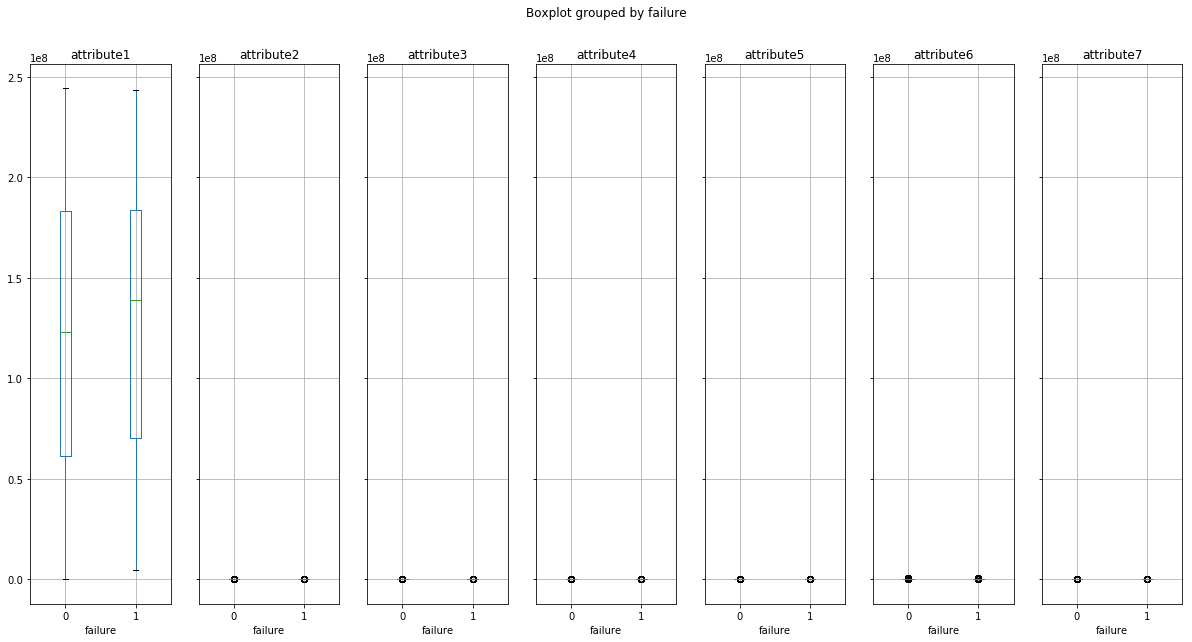

In [12]:
plt.figure(figsize = (30, 20))
device_data.boxplot(column = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7"],
                    by = "failure",
                    grid = True, figsize = (20, 10),
                    layout = (1, 7),
                    return_type = "axes")
plt.show()

### Derive new features
1. Take the log of features with large values
<br>
Attribute1 & attribute6 have very large values compared with the rest of the features. So I'll take the logs.
<p>
2. Create dummies (0/1) from the existing features
<br>
If the value of an attribute is larger than 0, encode as 1, otherwise 0

In [13]:
# 1) Calculate the log of the attribute1 & attribute6
columns_list = ["attribute1", "attribute6"]
createLog(device_data, columns_list)

# 2) Create dummies from the attributes
columns_list = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute9"]

features_dummy = createDummy(device_data, columns_list)
list(zip(features_dummy, [device_data[s].value_counts() for s in features_dummy]))

[('attribute1_dummy', 1    124483
  0        11
  Name: attribute1_dummy, dtype: int64), ('attribute2_dummy', 0    118110
  1      6384
  Name: attribute2_dummy, dtype: int64), ('attribute3_dummy', 0    115359
  1      9135
  Name: attribute3_dummy, dtype: int64), ('attribute4_dummy', 0    115156
  1      9338
  Name: attribute4_dummy, dtype: int64), ('attribute5_dummy', 1    124494
  Name: attribute5_dummy, dtype: int64), ('attribute6_dummy', 1    124494
  Name: attribute6_dummy, dtype: int64), ('attribute7_dummy', 0    123036
  1      1458
  Name: attribute7_dummy, dtype: int64), ('attribute9_dummy', 0    97358
  1    27136
  Name: attribute9_dummy, dtype: int64)]

We'll also drop the dummies for columns 5 & 6 because they are always 1. Since they have the same value for every observation, they won't provide any useful information to the models.

In [14]:
drop_vars = ["attribute5_dummy", "attribute6_dummy"]
device_data = device_data.drop(drop_vars, axis = 1)

### Further investigation of the data
We need to dig a little deeper into the distributions of failure/non-failure and understand the following:
<br>
1. Distribution of failure/non-failure rates by year
2. Distribution of failure/non-failure rates by month
3. Distribution of failure/non-failure rates by device - are there specific devices that tend to fail more than others?

In [15]:
# Distribution of failure/non-failure by year
device_data["year"] = pd.to_datetime(device_data["date"]).dt.year
device_data["month"] = pd.to_datetime(device_data["date"]).dt.month
device_data["day_of_week"] = pd.to_datetime(device_data["date"]).dt.dayofweek
device_data["device_type"] = device_data.device.str[0]

# Create dummies for each of the three different devices in the data. Each starts with a different letter - S, W, or Z
device_data = pd.concat([device_data, pd.get_dummies(device_data["device_type"].str.lower(), prefix = "device_type")],
                        axis = 1, join_axes = [device_data.index])

# Print some summary stats
print(device_data.failure.value_counts())

print(pd.crosstab(device_data["year"],
                  columns = "count"))
pd.crosstab(device_data["month"],
            columns = "count") / len(device_data.month)

0    124388
1       106
Name: failure, dtype: int64
col_0   count
year         
2015   124494


col_0,count
month,
1,0.201070
2,0.156634
3,0.159309
4,0.096487
5,0.091008
6,0.084092
7,0.084590
8,0.067039
9,0.035905


It is evident that the data is only for 2015 and we have information for most of the months of 2015, except for December. However, note that 50% of the observations are from the period January - March.
<p>
Next, we'll look at the distribution of failure/non-failure by month - both counts and rates.

In [16]:
# Distribution of failure/non-failure by month
failure_month = pd.crosstab(index = device_data["failure"],
                            columns = device_data["month"],
                            margins = True)

failure_month.index = ["non_failure", "failure", "month_total"]
failure_month

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failure,25008,19486,19824,12003,11309,10463,10515,8342,4470,2937,31,124388
failure,24,14,9,9,21,6,16,4,0,3,0,106
month_total,25032,19500,19833,12012,11330,10469,10531,8346,4470,2940,31,124494


In [17]:
failure_month_pct = failure_month / failure_month.loc["month_total"]
failure_month_pct

month,1,2,3,4,5,6,7,8,9,10,11,All
non_failure,0.999041,0.999282,0.999546,0.999251,0.998147,0.999427,0.998481,0.999521,1.0,0.99898,1.0,0.999149
failure,0.000959,0.000718,0.000454,0.000749,0.001853,0.000573,0.001519,0.000479,0.0,0.00102,0.0,0.000851
month_total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.0,1.000000


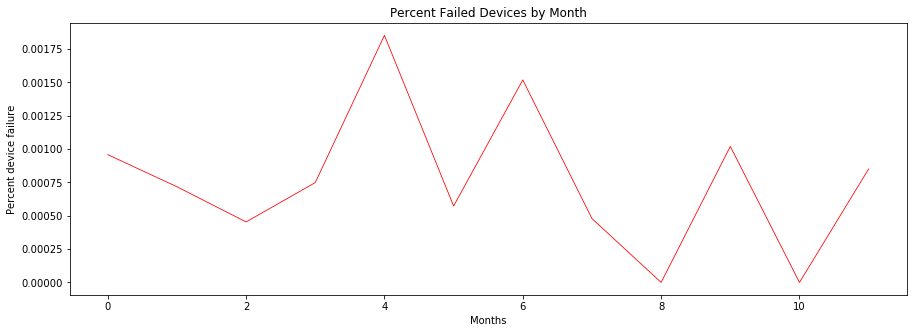

In [18]:
# Plot the % failures/non-failures by month
plt.figure(figsize = (15, 5))
plt.plot(list(failure_month_pct.loc["failure"]), linewidth = 0.8, color = "#ff0000")
plt.xlabel("Months")
plt.ylabel("Percent device failure")
plt.title("Percent Failed Devices by Month")

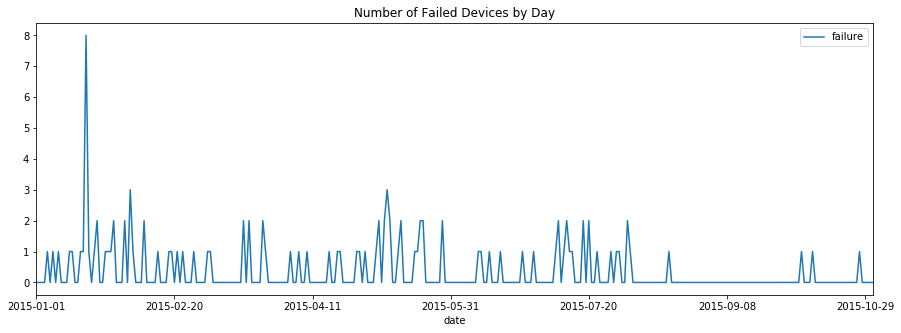

In [19]:
# Plot the % failures/non-failures by day
failure_day = pd.crosstab(index = device_data["date"],
                          columns = device_data["failure"],
                          margins = True)

failure_day.columns = ["non_failure", "failure", "total"]

failure_day[:-1].reset_index().plot(x = "date", y = "failure",
                                    figsize = (15, 5),
                                    title = "Number of Failed Devices by Day")

I noticed that the devices start with a different letter, which could be a different device type. Some types may have higher failure rates than others, and I'll explore to see if there are different failure rates by device type

In [20]:
# Distribution of failure/non-failure by device type - are there specific devices that tend to fail more than others?
failure_device = pd.crosstab(index = device_data["device_type"],
                             columns = device_data["failure"],
                             margins = True)
failure_device.columns = ["non_failure", "failure", "total"]

print (failure_device["failure"] / failure_device["total"])
failure_device

device_type
S      0.000766
W      0.000971
Z      0.000834
All    0.000851
dtype: float64


,non_failure,failure,total
device_type,,,
S,54816,42,54858
W,43226,42,43268
Z,26346,22,26368
All,124388,106,124494


It looks like the devices that start with the letter W have a slightly higher failure rate (0.000971) compared to the average (0.000851). Although, it is not too different. Nevertheless, I'll use the device type as dummy variables in the models.

In [21]:
# Are there particular days of the week when a higher percent of devices fail?
failure_day_week = pd.crosstab(index = device_data["day_of_week"],
                               columns = device_data["failure"],
                               margins = True)
failure_day_week

failure,0,1,All
day_of_week,,,
0,17859,27,17886
1,17516,18,17534
2,17121,15,17136
3,18119,22,18141
4,18029,12,18041
5,17889,8,17897
6,17855,4,17859
All,124388,106,124494


The devices don't seem to fail much during the weekends, which is interesting. We'll use the day-of-the-week feature as a predictor in the models.

In [22]:
# Prepare the data for the models
# Drop variables which will not be useful in the models
drop_from_analysis = ["date", "device", "year", "month", "device_type"]
analysis_set = device_data.drop(drop_from_analysis, axis = 1)

### Scale the features in the input dataset
Some of the features have very large values, compared to the remaining features, which will create a problem unless the features are scaled.

In [23]:
# Scale the features and sample from the scaled features
keep_columns = ["attribute1", "attribute2", "attribute3", "attribute4", "attribute5", "attribute6", "attribute7", "attribute9"]

scaler = MinMaxScaler()
analysis_set_scaled = pd.DataFrame(scaler.fit_transform(analysis_set[keep_columns]),
                                   columns = [(x + "_s") for x in keep_columns])

analysis_set = pd.concat([analysis_set, analysis_set_scaled], axis = 1, join_axes=[analysis_set.index])

### Sampling - create training and validation sets for the models
Next, we need to create training and validation datasets to use in modeling. The training will be 70% of original and validation the remaining 30%.
<p>
It is very important that when we create training and validation datasets, the rate of failure in those datasets remains the same as in the full set. If it's not the same as in the original dataset, our accuracy stats on the developed model will be wrong and cannot be trusted.
<p>
My initial plan for creating train and validation datasets was to use train_test_split() from sklearn. However, I was suspicious that with such a low rate of failure in the input dataset (0.000851), the train_test_split() function will not properly sample the data, and the resulting rates will be different.
<p>
I created samples with train_test_split(), but the problem is that the sampling process yields train/validation samples with different failure rates - in one of the draws, the training ended up having a failure rate which was about 1.5 times higher than in the original.
<p>
Therefore, I implemented a controled sampling from the original set.
<p>
After the sampling, the datasets are split into X and Y sets to use in the models.

In [24]:
# Split the data into training and validation - 70% training and 30% validation

sample_size = .7
_failure = analysis_set[analysis_set["failure"] == 1]
_non_failure = analysis_set[analysis_set["failure"] == 0]

# Create the training set - 70% of observations
_failure_t = _failure.sample(frac = sample_size,
                             replace = False,
                             weights = None,
                             random_state = 7894)

_non_failure_t = _non_failure.sample(frac = sample_size,
                                     replace = False,
                                     weights = None,
                                     random_state = 7894)

training_set = pd.concat([_failure_t, _non_failure_t])


# Create the validaton sample - drop the rows that were sampled for the training sets - 30% of observations
_failure_v = _failure.drop(_failure_t.index.tolist())
_non_failure_v = _non_failure.drop(_non_failure_t.index.tolist())

validation_set = pd.concat([_failure_v, _non_failure_v])


# Check if the % failure and non-failure remains the same in the training and validation as in the original dataset
_orig_f = Decimal(len(analysis_set[analysis_set["failure"] == 1])) / len(analysis_set[analysis_set["failure"] == 0])
print ("Rate of failures in the original set is %0.7f " % _orig_f)

_train_f = Decimal(len(training_set[training_set["failure"] == 1])) / len(training_set[training_set["failure"] == 0])
print ("Rate of failures in training is %0.7f" % _train_f)

_validate_f = Decimal(len(validation_set[validation_set["failure"] == 1])) / len(validation_set[validation_set["failure"] == 0])
print ("Rate of failures in validation is %0.7f" % _validate_f)


Rate of failures in the original set is 0.0008522 
Rate of failures in training is 0.0008499
Rate of failures in validation is 0.0008575


The failure rates are approximately the same in the training and validation sets, and the next step is to create the X and Y sets for the models.

In [25]:
# Create the X and Y sets for the models
x_train = training_set.drop("failure", axis = 1)
x_validate = validation_set.drop("failure", axis = 1)
y_train = training_set["failure"]
y_validate = validation_set["failure"]

In [26]:
# Use Synthetic Minority Oversampling (SMOTE) to balance the datasets
sm_params = {"ratio": "minority",
             "random_state": 7894}

sm = SMOTE(**sm_params)
_x_train, _y_train = sm.fit_sample(x_train, y_train)

x_train_w = pd.DataFrame(_x_train,
                         columns = list(x_train.columns))
y_train_w = pd.Series(_y_train)

# Check the counts - should have the same counts of failures and non-failures
y_train_w.value_counts()

1    87072
0    87072
dtype: int64

In [27]:
# Create training/validation sets for the feature reduction and a separate ones for the training of models
x_train = x_train_vs = x_train_w
y_train = y_train_w

### Variable selection
The next step in the model development process is to find the features that are most predictive for the outcome. I'll use recursive feature elimination and Random Forest for finding the features that are important.

In [28]:
# 1) Variable selection with Recursive Feature Elimination
vs_rfe = RFE(LogisticRegression())
vs_rfe.fit(x_train_vs, y_train)
list(zip(x_train_vs, vs_rfe.support_, vs_rfe.ranking_))

[('attribute1', False, 13),
 ('attribute2', False, 7),
 ('attribute3', False, 4),
 ('attribute4', True, 1),
 ('attribute5', False, 2),
 ('attribute6', False, 9),
 ('attribute7', True, 1),
 ('attribute9', False, 3),
 ('attribute1_log', True, 1),
 ('attribute6_log', True, 1),
 ('attribute1_dummy', True, 1),
 ('attribute2_dummy', True, 1),
 ('attribute3_dummy', True, 1),
 ('attribute4_dummy', True, 1),
 ('attribute7_dummy', True, 1),
 ('attribute9_dummy', True, 1),
 ('day_of_week', True, 1),
 ('device_type_s', True, 1),
 ('device_type_w', True, 1),
 ('device_type_z', True, 1),
 ('attribute1_s', False, 15),
 ('attribute2_s', False, 12),
 ('attribute3_s', False, 11),
 ('attribute4_s', False, 8),
 ('attribute5_s', False, 5),
 ('attribute6_s', False, 14),
 ('attribute7_s', False, 6),
 ('attribute9_s', False, 10)]

It appears that the recursive feature elimination suggests that we don't use in the model any of the dummies, except for the dummy for attribute1, and we shouldn't use the indicator for the type of device (s, w, z).
<p>
Let's start with a decision tree algorithm and see which variable are good predictors. I'll build a decision tree to understand if there are any features from which we need to create categories.

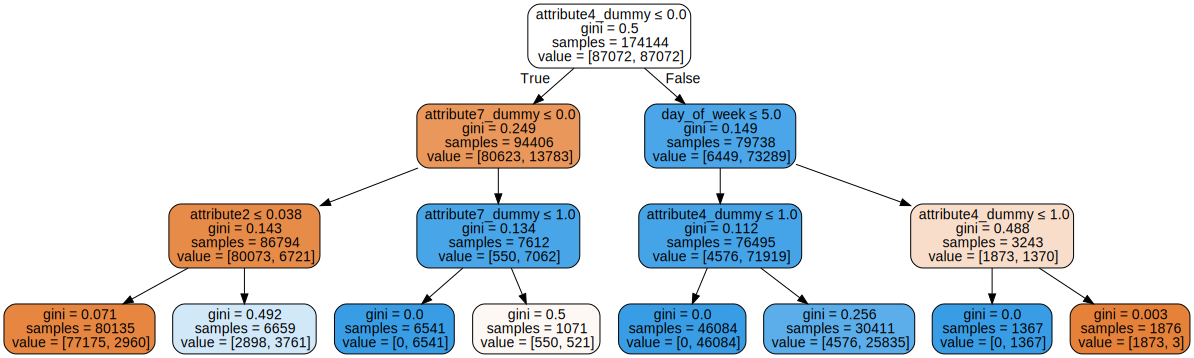

In [29]:
# Specify the decision tree model and fit
dt_params = {"criterion": "gini",    
             "random_state": 0,
             "max_depth": 3,
             "min_samples_split": 20}

vs_model_dt = DecisionTreeClassifier(**dt_params)
vs_model_dt.fit(x_train, y_train)

# Visualize the decision tree
# Export the data from the decision tree as a DOT object
dt_viz = export_graphviz(vs_model_dt,
                         out_file = None,
                         feature_names = list(x_train),
                         filled = True, rounded = True,
                         special_characters = True)


# Plot the tree and explore which features split the tree
graphviz.Source(dt_viz)

Let's see what Random Forest suggests as important variables.

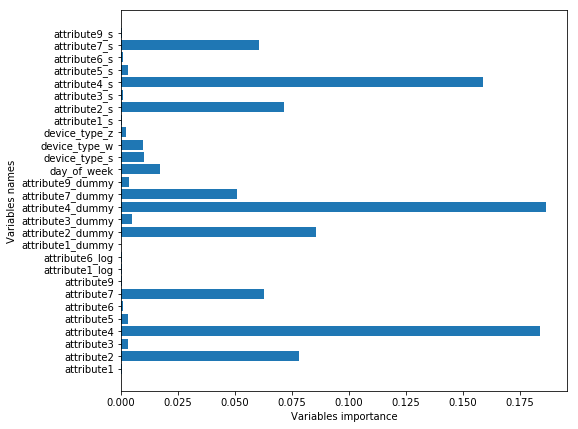

In [30]:
# 2) Variable selection using the feature importance from Random Forest
# At this step Random Forest is used only as a feature selection method. I'll obtain the feature importance from RF
# At a later stage, I'll also use Random Forest as a classification model

rf_vs_params = {"n_estimators": 1000,             # From prior experience I've noticed that a few hundred trees are usually enough for small datasets
                "random_state": 0,
                "max_depth": 3                  # We don't have much observations, so that's why I set max tree depth to 3
                #,"class_weight": "balanced"      # Note needed when the dataset has been balanced with SMOTE
               }

model_rf_vs = RandomForestClassifier(**rf_vs_params)
model_rf_vs.fit(x_train_vs, y_train)

# Plot the feature importance values
def plotFeatureImportance(model, x_data):
    plt.figure(figsize = (8, 7))
    num_features = len(list(x_data.columns))
    plt.barh(range(num_features), model.feature_importances_)
    plt.yticks(np.arange(num_features), list(x_data.columns))
    plt.xlabel("Variables importance")
    plt.ylabel("Variables names")
    
plotFeatureImportance(model_rf_vs, x_train_vs)

Based on the variable importance plot, I'll drop certain features, and will re-run the Random Forest selection.

In [ ]:
# Drop weak variables
drop_col = ["attribute1", "attribute3", "attribute5", "attribute6", "attribute9", "attribute1_log", "attribute6_log",
            "attribute1_dummy", "attribute3_dummy", "attribute9_dummy",
            "device_type_z", "device_type_w", "device_type_s",
            "attribute1_s", "attribute3_s", "attribute5_s", "attribute6_s", "attribute9_s"]

x_train_vs = x_train_vs.drop(drop_col, axis = 1)


# Re-run feature importance
rf_vs_params = {"n_estimators": 500,
                "random_state": 0,
                "max_depth": 3,
                "class_weight": "balanced"}

model_rf_vs = RandomForestClassifier(**rf_vs_params)
model_rf_vs.fit(x_train_vs, y_train)

# Plot the feature importance values
def plotFeatureImportance(model, x_data):
    plt.figure(figsize = (8, 7))
    num_features = len(list(x_data.columns))
    plt.barh(range(num_features), model.feature_importances_)
    plt.yticks(np.arange(num_features), list(x_data.columns))
    plt.xlabel("Variables importance")
    plt.ylabel("Variables names")
    
plotFeatureImportance(model_rf_vs, x_train_vs)

Print goodness-of-fit stats from Logistic regression.
<br>
These stats give us an idea of the explanatory power of each variable, and guide our decision which varaibles to use in the models.

In [134]:
import statsmodels.api as sm

model_lr_vs = sm.Logit(y_train, x_train_vs).fit()
print(model_lr_vs.summary())

         Current function value: 0.338738
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               174144
Model:                          Logit   Df Residuals:                   174125
Method:                           MLE   Df Model:                           18
Date:                Tue, 23 Jan 2018   Pseudo R-squ.:                  0.5113
Time:                        08:39:17   Log-Likelihood:                -58989.
converged:                      False   LL-Null:                   -1.2071e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
attribute1        5.625e-10        nan        nan        nan         nan         nan
attribute2       -2.229e-05    111.744     -2e-

/Users/valentin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/valentin/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/valentin/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/valentin/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/valentin/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### Use XG Boost for variable selection

In [34]:
cv_params = {"max_depth": [3, 5, 7],
             "min_child_weight": [1, 3, 5]}

xgb_params = {"learning_rate": 0.05,
              "n_estimators": 100,
              "random_state": 0,
              "subsample": 0.5,
              "colsample_bytree": 0.5,
              "objective": "binary:logistic",
              "silent": 0}

model_xgb_vs = xgb.XGBClassifier(**xgb_params)

xgb_cv = GridSearchCV(model_xgb_vs,
                      cv_params,
                      scoring = 'accuracy', cv = 5, n_jobs = -1, verbose = True
                      
                      # Methods to adjust imbalanced data
                      #, scale_pos_weight = 1.0         # sum(negative) / sum(positive) When only rank ordering is important - use AUC for eval
                      #, max_delta_step                 # When the right probability is important
                      )

In [35]:
xgb_cv.fit(x_train_vs, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  6.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_child_weight': [1, 3, 5], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=True)

In [36]:
xgb_cv.cv_results_

{'mean_fit_time': array([ 19.97109656,  21.06564913,  23.00225873,  37.39497318,
         32.45519681,  31.4517395 ,  39.98157444,  39.17792301,  36.14026723]),
 'mean_score_time': array([ 0.12138162,  0.1860218 ,  0.17289052,  0.24475126,  0.18112435,
         0.1886209 ,  0.19514341,  0.19908738,  0.17698202]),
 'mean_test_score': array([ 0.98659156,  0.98628147,  0.98652265,  0.9963134 ,  0.99612964,
         0.99588272,  0.99935111,  0.99933963,  0.99931092]),
 'mean_train_score': array([ 0.98656715,  0.98632023,  0.98640206,  0.99652012,  0.99629761,
         0.99610811,  0.99952769,  0.99950903,  0.99946596]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 3 5 1 3 5 1 3 5],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 3, 'min_child_w

Use grid search cross validation to optimize settings for XG Boost

In [72]:
xgdmat = xgb.DMatrix(x_train_vs, y_train) # Create our DMatrix to make XGBoost more efficient

xgdmat_params = {"eta": 0.05,
                 "seed": 0,
                 "subsample": 0.8,
                 "colsample_bytree": 0.8,
                 "objective": "binary:logistic",             
                 "max_depth": 7,             
                 "min_child_weight": 5}

model_xgb_vs = xgb.cv(params = xgdmat_params,
                      dtrain = xgdmat,
                      num_boost_round = 3000,
                      nfold = 5,
                      metrics = ["error"],
                      early_stopping_rounds = 100)

In [73]:
# Check how the model did
model_xgb_vs.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
354,0.000442,0.000086,0.000361,0.000025
355,0.000442,0.000086,0.000362,0.000026
356,0.000442,0.000086,0.000357,0.000021
357,0.000442,0.000086,0.000356,0.000020
358,0.000431,0.000081,0.000357,0.000021


In [74]:
# If needed, adjust parameters and save them in an object which is passed to the training
final_xgb_params = {"eta": 0.1,
                    "seed": 0,
                    "subsample": 0.8,
                    "colsample_bytree": 0.8,
                    "objective": "binary:logistic",
                    "max_depth": 3,
                    "min_child_weight": 1}

final_model_xgb_vs = xgb.train(final_xgb_params,
                               xgdmat,
                               num_boost_round = 358)

In [75]:
importances = final_model_xgb_vs.get_fscore()

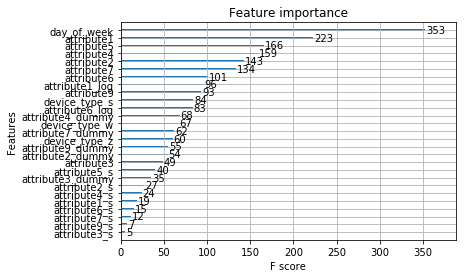

In [76]:
xgb.plot_importance(final_model_xgb_vs)

Before continuing with the models, make sure that the features in the validation sample are the same as those in the training. If they are not the same, the model will error out.

In [77]:
x_validate = x_validate[list(x_train.columns)]

## Models
The following section contains the models I developed on the dataset. Each of the models will be trained and validated on two different datasets - scaled and synthetic dataset created with SMOTE.
<p>
The best models will be plotted on a ROC curve and print out the confusion matrix for each.
<p>
1. Logistic regression - This is the standard method for developing binary classification models. We'll use the logistic regression as a benchmark for all other methods
2. Random forest classifier
3. Gradient boosting with XGboost
4. Support vector machine

### 1. Logistic regression

In [78]:
lr_params = {"C": 1.0,
             "penalty": "l2",
             "class_weight": "balanced"}    # parameter to adjust for the imbalanced dataset. Weights are proportional to class frequencies.

model_lr = LogisticRegression(**lr_params)
model_lr.fit(x_train, y_train)


# Predict on training set and check the accuracy
modelAccuracyStats(model_lr, "Logistic regression", x_train, y_train, x_validate, y_validate)

Print stats for method: Logistic regression

The number of False Negative in the validation set is 16 
The number of False Positive in the validation set is 3427 

Accuracy on training set is 0.67479
Recall (tp/(tp+fn)) of training set is 0.44207

Accuracy on validation set is 0.90781
Recall (tp/(tp+fn)) of validation set is 0.50000


### 2. Random forest classifier

In [79]:
rf_params = {"n_estimators": 1000,
             "random_state": 0,
             "verbose": 0,
             "max_depth": 3,
             "n_jobs": -1,
             "criterion": "gini",
             "class_weight": "balanced"}

model_rf = RandomForestClassifier(**rf_params)
model_rf.fit(x_train, y_train)

# Predict on training set and check the accuracy
modelAccuracyStats(model_rf, "Random Forest", x_train, y_train, x_validate, y_validate)

Print stats for method: Random Forest

The number of False Negative in the validation set is 7 
The number of False Positive in the validation set is 3021 

Accuracy on training set is 0.94303
Recall (tp/(tp+fn)) of training set is 0.96595

Accuracy on validation set is 0.91892
Recall (tp/(tp+fn)) of validation set is 0.78125


### 3. Gradient boosting with XGboost

In [ ]:
xgdmat = xgb.DMatrix(x_train, y_train) # Create our DMatrix to make XGBoost more efficient

xgb_cv_params = {"eta": 0.1,              
                 "seed": 0,      
                 "subsample": 0.8,             
                 "colsample_bytree": 0.8,             
                 "objective": "binary:logistic",            
                 "max_depth": 3,
                 "min_child_weight": 1}

model_xgb = xgb.cv(params = xgb_cv_params,
                      dtrain = xgdmat,
                      num_boost_round = 3000,
                      nfold = 5,
                      metrics = ["error"],
                      early_stopping_rounds = 100)

# Check how the model did
model_xgb.tail(5)

In [83]:
# If needed, adjust parameters and save them in an object which is passed to the training
xgb_cv_params = {"eta": 0.1,        # 0.01             
                 "seed": 0,               
                 "subsample": 0.8,                 
                 "colsample_bytree": 0.8,                 
                 "objective": "binary:logistic",                 
                 "max_depth": 3,                 
                 "min_child_weight": 3}

model_xgb = xgb.train(xgb_cv_params,                    
                      xgdmat,                      
                      num_boost_round = 358)

In [96]:
validate_dmat = xgb.DMatrix(x_validate)
y_pred_xgb = model_xgb.predict(validate_dmat) # Predict using our testdmat


### 4. Support vector machine
SVM expects that all features have similar mean and stddev. Rescale the features before feeding the data to the model.

In [135]:
# Sampling for SVM
analysis_set_s = analysis_set[["failure", "attribute2", "attribute4", "attribute7",
                               "attribute1_s", "attribute2_s", "attribute3_s", "attribute4_s", "attribute5_s", "attribute6_s",
                              "attribute7_s", "attribute9_s",
                              "attribute1_dummy", "attribute2_dummy", "attribute3_dummy",
                              "attribute4_dummy",
                              "attribute7_dummy",
                              "attribute9_dummy",
                              "day_of_week",
                              "device_type_s",
                              "device_type_w",
                              "device_type_z"]]

x_train_s, x_validate_s, y_train_s, y_validate_s = train_test_split(analysis_set_s.drop(["failure"], axis = 1),
                                                                    analysis_set_s["failure"],
                                                                    train_size = .7)

# Test if the % failure and non-failure remains the same in the new datasets as in the original dataset
print ("The rate of failures in the original set is " + str(Decimal(float(analysis_set["failure"].value_counts()[1])) / sum(analysis_set["failure"].value_counts())))
print ("The rate of failures in the training set is " + str(Decimal(float(y_train_s.value_counts()[1])) / sum(y_train_s.value_counts())))
print ("The rate of failures in the validation set is " + str(Decimal(float(y_validate_s.value_counts()[1])) / sum(y_validate_s.value_counts())))


The rate of failures in the original set is 0.0008514466560637460439860555529
The rate of failures in the training set is 0.0008491594468988467496700900798
The rate of failures in the validation set is 0.0008567833141449570269618999170


In [136]:
svm_params = {"C": 1.0,
              "degree": 3,
              "class_weight": "balanced",
              "probability": True}

model_svm = svm.SVC(**svm_params)

model_svm.fit(x_train_s, y_train_s,
              sample_weight = None)

modelAccuracyStats(model_svm, "SVM", x_train_s, y_train_s, x_validate_s, y_validate_s)

Print stats for method: SVM

The number of False Negative in the validation set is 31 
The number of False Positive in the validation set is 343 

Accuracy on training set is 0.99013
Recall (tp/(tp+fn)) of training set is 0.85135

Accuracy on validation set is 0.98999
Recall (tp/(tp+fn)) of validation set is 0.03125


### Models evaluation
The models evaluation is done using the Receiver Operating Characteristics (ROC) curve and a confusion matrix.

In [100]:
# 1) Use the ROC curve to evaluate accuracy of each model
# Obtain the parameters needed for each ROC curve for each model
y_pred_lr = model_lr.predict_proba(x_validate)[::, 1]
roc_lr = roc_auc_score(y_validate, y_pred_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_validate, y_pred_lr)

y_pred_rf = model_rf.predict_proba(x_validate)[::, 1]
roc_rf = roc_auc_score(y_validate, y_pred_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_validate, y_pred_rf)

roc_xgb = roc_auc_score(y_validate, y_pred_xgb)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_validate, y_pred_xgb)

#y_pred_svm = model_svm.predict_proba(x_validate_s)[::, 1]
#roc_svm = roc_auc_score(y_validate_s, y_pred_svm)
#fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_validate_s, y_pred_svm)

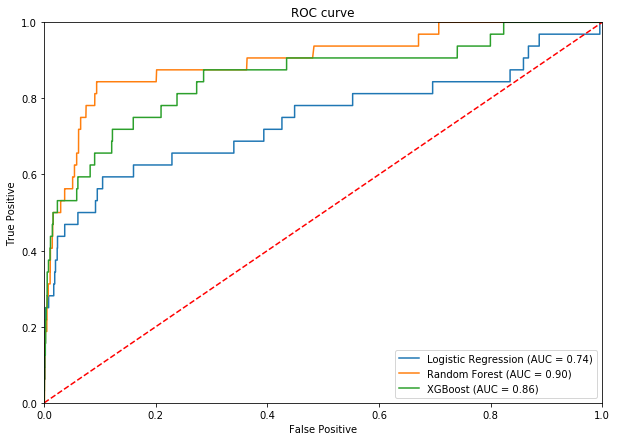

In [101]:
# Plot the ROC curve
plt.figure(figsize = (10, 7))
plt.plot(fpr_lr, tpr_lr, label = "Logistic Regression (AUC = %0.2f)" % roc_lr)
plt.plot(fpr_rf, tpr_rf, label = "Random Forest (AUC = %0.2f)" % roc_rf)
plt.plot(fpr_xgb, tpr_xgb, label = "XGBoost (AUC = %0.2f)" % roc_xgb)
#plt.plot(fpr_svm, tpr_svm, label = "SVM (AUC = %0.2f)" % roc_svm)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC curve")
plt.legend(loc = "lower right")


In [142]:
# 2) Create a table that prints out the confusion matrices for each model
from sklearn.metrics import confusion_matrix

cm_df = np.stack((confusionMatrix(model_lr, x_validate, y_validate),
                  confusionMatrix(model_rf, x_validate, y_validate),
                  confusionMatrix(model_xgb, x_validate_s, y_validate_s),
                  confusionMatrix(model_svm, x_validate_s, y_validate_s)))

cm_df = pd.DataFrame(cm_df,
                     index = ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
                     columns = ["True Negative", "False Positive", "False Negative", "True Positive"])
cm_df

,True Negative,False Positive,False Negative,True Positive
Logistic Regression,34680,2636,8,24
Random Forest,33843,3473,5,27
XGBoost,37316,1,30,2
SVM,36974,343,31,1
